# Vorhersage der Schwere eines Unfalls in Frankreich

Idee dieses Projektes ist, Voraussagen über den Ausgang eines Vehrsunfalls in Frankreich treffen zu können. Die Labels sind also 1:' Unharmed' 2: 'Killed', 3: 'Injured hospitalized', 4: 'Slightly injured'.    
Wir benutzen hier franzöische Daten, weil die Unfälle in unserem Nachbarland sehr genau erfasst werden (siehe sazu weiter unten unsere Erklärung der einzelnen Features). Beispielsweise werden neben dem Alter und dem Geschlecht auch Fahrzeugkategorie und bis zu drei Sicherheitsausrüstungen(bspw. Helm bei Motorradfahrern oder Gürtel beim Auto oder Bus) genannt und sogar die Entfernung zum nächten Nottelefon auf der Autobahn. Die Anzahl der Features (über 40) läst uns gute Voraussagen treffen.   
## Pakete einbinden

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

# Daten einlesen und übersetzen

Der Datensatz liegt in vier Tabellen vor, die einzeln eingelesen werden. Die Spalten werden übersetzt.

In [2]:
characteristics = pd.read_csv('caracteristiques-2019.csv')
characteristics.rename(columns={'Num_Acc': 'ID_Acc', 'jour': 'Day', 'mois': 'Month', 'an': 'Year', 'hrmn': 'Time', 'lum': 'Light', 'dep': 'Department','com': 'Municipality','agg': 'Location'}, inplace=True)

places = pd.read_csv('lieux-2019.csv')
places.rename(columns={'Num_Acc': 'ID_Acc', "catr": "road_cat", "voie": "route_num", "v1": "road_index1", "v2": "road_index2", "circ": "traffic_regime", "nbv": "traffic_lanes", "vosp": "reserved_lane","pr":"upstream_terminal","pr1":"distance_to_upstream", "lartpc": "central_reservation_width", "larrout": "roadwidth_vehicles", "vma": "speed_limit"}, inplace=True)

drivers = pd.read_csv('usagers-2019.csv')
drivers.rename(columns={'Num_Acc': 'ID_Acc', 'id_vehicule': 'ID_veh', 'num_veh': 'Vehicle_No', 'catu': 'User_category', 'grav': 'Severity', 'sexe': 'Gender_driver', 'an_nais': 'DOB_driver','trajet': 'Reason_for_travel','secu1': 'Safety_equip_1','secu2': 'Safety_equip_2','secu3': 'Safety_equip_3', 'locp': 'Ped_loc', 'actp': 'Ped_act', 'etatp': 'Ped_acc'}, inplace=True)

vehicles = pd.read_csv('vehicules-2019.csv')
vehicles.rename(columns={'Num_Acc': 'ID_Acc', 'id_vehicule': 'ID_veh', 'num_veh': 'Vehicle_No', 'catv': 'Vehicle_category', 'obs': 'Fix_Obst_st', 'obsm': 'Mov_Obst_st', 'choc': 'Shock_pt','manv': 'Maneuver','occutc': 'No.of_occupants', 'senc': 'Flow_Direction'}, inplace=True)


characteristics = characteristics.set_index('ID_Acc')
places = places.set_index('ID_Acc')
drivers = drivers.set_index('ID_veh')
vehicles = vehicles.set_index('ID_veh')

In [3]:
characteristics

,Day,Month,Year,Time,Light,Department,Municipality,Location,int,atm,col,adr,lat,long
ID_Acc,,,,,,,,,,,,,,
201900000001,30.0,11.0,2019.0,0.062500,4.0,93,93053,1.0,1.0,1.0,2.0,AUTOROUTE A3,488962100.0,24701200.0
201900000002,30.0,11.0,2019.0,0.118056,3.0,93,93066,1.0,1.0,1.0,6.0,AUTOROUTE A1,489307000.0,23688000.0
201900000003,28.0,11.0,2019.0,0.635417,1.0,92,92036,1.0,1.0,1.0,4.0,AUTOROUTE A86,489358718.0,23191744.0
201900000004,30.0,11.0,2019.0,0.847222,5.0,94,94069,1.0,1.0,1.0,4.0,A4,488173295.0,24281502.0
201900000005,30.0,11.0,2019.0,0.166667,3.0,94,94028,1.0,1.0,1.0,2.0,A86 INT,487763620.0,24332540.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201900058836,30.0,11.0,2019.0,0.375000,1.0,69,69288,1.0,1.0,5.0,2.0,A43 13.029 A 15.971,456666600.0,50561200.0
201900058837,27.0,11.0,2019.0,0.326389,1.0,67,67482,1.0,1.0,8.0,4.0,Autoroute A.35,485769000.0,77269000.0
201900058838,30.0,11.0,2019.0,0.111806,4.0,94,94021,1.0,1.0,1.0,6.0,AUTOROUTE A6A,487717000.0,23457600.0


In [4]:
places

,road_cat,route_num,road_index1,road_index2,traffic_regime,traffic_lanes,reserved_lane,prof,upstream_terminal,distance_to_upstream,plan,central_reservation_width,roadwidth_vehicles,surf,infra,situ,speed_limit
ID_Acc,,,,,,,,,,,,,,,,,
201900000001,1.0,3,0.0,NaN,3.0,10.0,0.0,1.0,6.0,900.0,2.0,NaN,NaN,1.0,2.0,1.0,70.0
201900000002,1.0,1,0.0,NaN,1.0,2.0,0.0,4.0,3.0,845.0,2.0,NaN,NaN,1.0,0.0,1.0,70.0
201900000003,1.0,86,0.0,NaN,3.0,8.0,0.0,1.0,10.0,500.0,3.0,NaN,NaN,1.0,0.0,1.0,90.0
201900000004,1.0,4,0.0,NaN,3.0,5.0,0.0,1.0,2.0,299.0,1.0,NaN,NaN,1.0,0.0,1.0,90.0
201900000005,1.0,86,0.0,INT,1.0,3.0,0.0,1.0,41.0,0.0,3.0,NaN,NaN,1.0,2.0,1.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201900058836,1.0,43,0.0,NaN,1.0,3.0,0.0,1.0,15.0,500.0,1.0,NaN,NaN,2.0,3.0,1.0,130.0
201900058837,1.0,35,0.0,NaN,1.0,2.0,0.0,1.0,303.0,282.0,1.0,NaN,NaN,2.0,0.0,1.0,90.0
201900058838,1.0,6,0.0,A,3.0,3.0,0.0,1.0,5.0,199.0,1.0,NaN,NaN,1.0,0.0,1.0,90.0


In [5]:
vehicles

,ID_Acc,Vehicle_No,Flow_Direction,Vehicle_category,Fix_Obst_st,Mov_Obst_st,Shock_pt,Maneuver,motor,No.of_occupants
ID_veh,,,,,,,,,,
138 306 524,201900000001,B01,2,7,0,2,5,23,1,NaN
138 306 525,201900000001,A01,2,17,1,0,3,11,1,NaN
138 306 523,201900000002,A01,1,7,4,0,1,0,1,NaN
138 306 520,201900000003,A01,1,7,0,2,1,2,1,NaN
138 306 521,201900000003,B01,1,7,1,0,4,2,1,NaN
...,...,...,...,...,...,...,...,...,...,...
137 982 135,201900058837,C01,1,7,0,2,1,2,1,NaN
137 982 132,201900058838,A01,2,7,3,0,1,21,0,NaN
137 982 131,201900058839,A01,2,33,0,0,7,1,1,NaN


In [6]:
drivers

,ID_Acc,Vehicle_No,place,User_category,Severity,Gender_driver,DOB_driver,Reason_for_travel,Safety_equip_1,Safety_equip_2,Safety_equip_3,Ped_loc,Ped_act,Ped_acc
ID_veh,,,,,,,,,,,,,,
138 306 524,201900000001,B01,2,2,4,2,2002,0,1,0,-1,-1,-1,-1
138 306 524,201900000001,B01,1,1,4,2,1993,5,1,0,-1,-1,-1,-1
138 306 525,201900000001,A01,1,1,1,1,1959,0,1,0,-1,-1,-1,-1
138 306 523,201900000002,A01,1,1,4,2,1994,0,1,0,-1,-1,-1,-1
138 306 520,201900000003,A01,1,1,1,1,1996,0,1,0,-1,-1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137 982 135,201900058837,C01,1,1,4,2,1988,1,1,0,-1,-1,-1,-1
137 982 132,201900058838,A01,1,1,4,1,1998,9,1,0,-1,-1,-1,-1
137 982 131,201900058839,A01,1,1,3,1,1979,0,2,0,-1,-1,-1,-1


# Datensatz zusammenfügen

Kurze Erklärung, wieso kein einfacher Merge funktioniert: bei den ersten beiden Datzensätzen wird die ID nicht als int64, sondern als object gespeichert, weil sie den vorhanden Speicherplatz für eine "C-long" übersteigt. Deshalb ist auch eine Umwandlung zu diesem dtype nicht möglich. Folgende Fehlermeldung kommt: *Python int too large to convert to C long*. Pandas gleift auf C zurück und dort sind keine so großen Zahlen möglich.    
     
Ein merge ist auf Zeilen mit unterschiedlichen dtypes nicht möglich: *You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat*. Wie uns die Fehlermeldung rät, benutzen wir pd.concat.

In [7]:
df_acc = pd.concat([characteristics, places.reindex(characteristics.index)], axis=1)
df_veh = pd.concat([drivers, vehicles.reindex(drivers.index)], axis=1)

In [8]:
df_acc = df_acc.loc[:, ~df_acc.columns.duplicated()]
df_veh = df_veh.loc[:, ~df_veh.columns.duplicated()]

df_veh.reset_index(drop=True, inplace=True)

df_veh.index = df_veh['ID_Acc'].astype('str')

df_veh = df_veh.drop(['ID_Acc'], axis=1)

df = pd.concat([df_acc.reindex(df_veh.index), df_veh], axis=1)

In [9]:
df

,Day,Month,Year,Time,Light,Department,Municipality,Location,int,atm,...,Ped_act,Ped_acc,Flow_Direction,Vehicle_category,Fix_Obst_st,Mov_Obst_st,Shock_pt,Maneuver,motor,No.of_occupants
ID_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,30.0,11.0,2019.0,0.062500,4.0,93,93053,1.0,1.0,1.0,...,-1,-1,2,7,0,2,5,23,1,NaN
201900000001,30.0,11.0,2019.0,0.062500,4.0,93,93053,1.0,1.0,1.0,...,-1,-1,2,7,0,2,5,23,1,NaN
201900000001,30.0,11.0,2019.0,0.062500,4.0,93,93053,1.0,1.0,1.0,...,-1,-1,2,17,1,0,3,11,1,NaN
201900000002,30.0,11.0,2019.0,0.118056,3.0,93,93066,1.0,1.0,1.0,...,-1,-1,1,7,4,0,1,0,1,NaN
201900000003,28.0,11.0,2019.0,0.635417,1.0,92,92036,1.0,1.0,1.0,...,0,-1,1,7,0,2,1,2,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201900058837,27.0,11.0,2019.0,0.326389,1.0,67,67482,1.0,1.0,8.0,...,-1,-1,1,7,0,2,1,2,1,NaN
201900058838,30.0,11.0,2019.0,0.111806,4.0,94,94021,1.0,1.0,1.0,...,-1,-1,2,7,3,0,1,21,0,NaN
201900058839,30.0,11.0,2019.0,0.638889,1.0,78,78640,1.0,1.0,1.0,...,-1,-1,2,33,0,0,7,1,1,NaN


<AxesSubplot:xlabel='Severity', ylabel='count'>

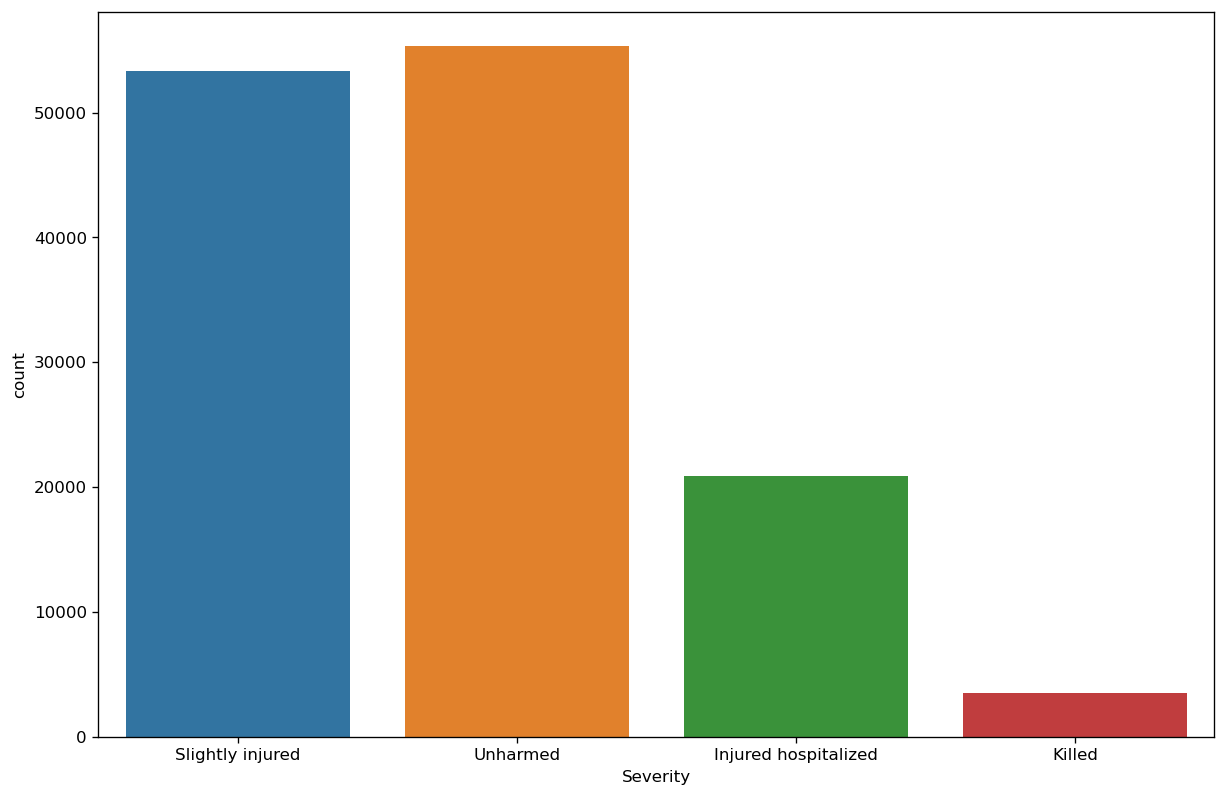

In [10]:
sns.countplot(df['Severity'].map({1: 'Unharmed',
                                  2: 'Killed',
                                  3: 'Injured hospitalized',
                                  4: 'Slightly injured'
                                  }))

In [11]:
df.select_dtypes(include=['float64', 'int64']).columns

Index(['Day', 'Month', 'Year', 'Time', 'Light', 'Location', 'int', 'atm',
       'col', 'lat', 'long', 'road_cat', 'road_index1', 'traffic_regime',
       'traffic_lanes', 'reserved_lane', 'prof', 'upstream_terminal',
       'distance_to_upstream', 'plan', 'central_reservation_width',
       'roadwidth_vehicles', 'surf', 'infra', 'situ', 'speed_limit', 'place',
       'User_category', 'Severity', 'Gender_driver', 'DOB_driver',
       'Reason_for_travel', 'Safety_equip_1', 'Safety_equip_2',
       'Safety_equip_3', 'Ped_loc', 'Ped_acc', 'Flow_Direction',
       'Vehicle_category', 'Fix_Obst_st', 'Mov_Obst_st', 'Shock_pt',
       'Maneuver', 'motor', 'No.of_occupants'],
      dtype='object')

<AxesSubplot:xlabel='Severity', ylabel='DOB_driver'>

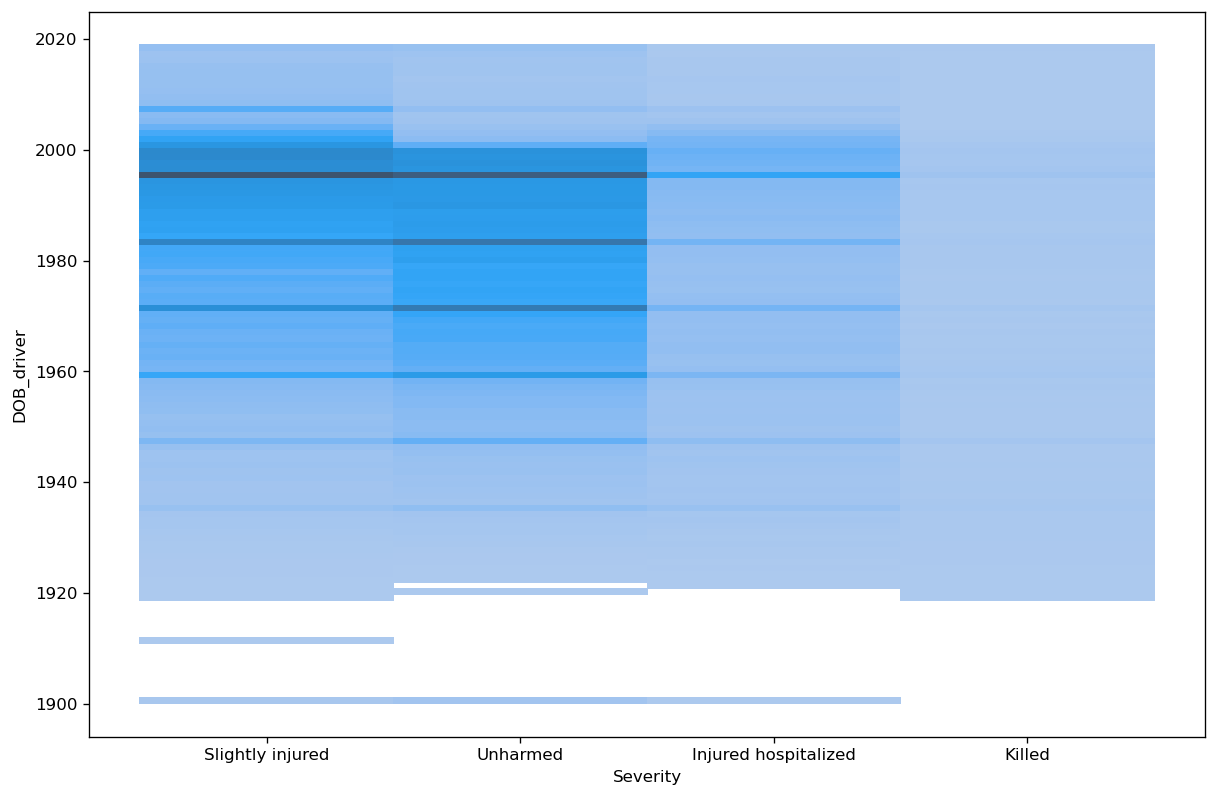

In [12]:
sns.histplot(y=df["DOB_driver"], x=df["Severity"].map({1: 'Unharmed',
                                                       2: 'Killed',
                                                       3: 'Injured hospitalized',
                                                       4: 'Slightly injured'
                                                       }))

In [55]:
###############ab hier encoding der string variablen#################

In [56]:
from sklearn.preprocessing import LabelEncoder
def encoding(df):
    label = LabelEncoder()
    for c in df.select_dtypes("object"):
        df[c]=df[c].astype(str)
        df[c]=label.fit_transform(df[c])
    return df

stringcolumns = df.select_dtypes("object")

df = encoding(df)

# ----------------------------------------------------------------------------

In [ ]:
df = pd.read_csv("accidents2019.csv")

In [58]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.model_selection import GridSearchCV

# Ab hier nur mit Autobahndaten

# SVC

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC().fit(X_train, y_train)

In [ ]:
svc.score(X_train, y_train)

In [ ]:
svc.score(X_test, y_test)

In [ ]:
params_svc = {
    'C': [100, 1000, 10000],
}

In [ ]:
%%time
gsc_scv = GridSearchCV(SVC(), params_svc)
gsc_scv.fit(X_train, y_train)

In [ ]:
gsc_scv.best_params_

In [ ]:
bpsvc = SVC(**gsc_scv.best_params_)

In [ ]:
bpsvc.fit(X_train, y_train)

In [ ]:
bpsvc.score(X_test, y_test)

In [ ]:
bpsvc.score(X_train, y_train)

# Ausgabe für Abgabe

In [ ]:
gnb = GaussianNB()
knc = KNeighborsClassifier()
rfc = RandomForestClassifier()

clfs = [gnb, knc, rfc]

Im Folgenden beschränken wir uns auf die Unfälle auf Autobahnen:

In [78]:
from sklearn.preprocessing import StandardScaler

In [79]:
X = StandardScaler().fit(X)

In [61]:
df_highway = df.loc[df["road_cat"] == 1]

In [62]:
X, y = df_highway.drop(columns="Severity"), df_highway["Severity"]

In [80]:
PCA().fit(X_train).explained_variance_ratio_

array([8.72210841e-01, 1.27789157e-01, 1.43113295e-09, 5.08399582e-10,
       9.86401962e-12, 1.85795416e-14, 1.05411158e-14, 3.16896698e-15,
       2.74555434e-15, 1.83531196e-15, 7.10361547e-16, 4.36249771e-16,
       3.22501933e-16, 3.14650784e-16, 2.38934337e-16, 2.07148965e-16,
       1.61360498e-16, 1.21095085e-16, 9.98673602e-17, 9.38235817e-17,
       8.81419991e-17, 8.57147763e-17, 7.71942973e-17, 7.04677196e-17,
       6.05834691e-17, 5.18183697e-17, 2.96395920e-17, 2.41441095e-17,
       2.06612609e-17, 1.98876834e-17, 1.48594289e-17, 1.38611748e-17,
       1.12297116e-17, 9.92338674e-18, 9.12357575e-18, 7.73364141e-18,
       7.56080843e-18, 3.25905681e-18, 2.11543179e-18, 8.11521517e-19,
       6.09963937e-19, 8.68356059e-33])

Die ersten zwei Komponenten erklären bereits 99% der Varianz, wir können uns also auf diese beiden beschränken:

In [ ]:
X = PCA(n_components=2).fit(X).transform(X)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
%%time
scores = []
for clf in clfs:
    clf.fit(X_train, y_train)
    scores.append((str(clf), clf.score(X_train, y_train), clf.score(X_test, y_test)))

In [ ]:
scores

## Mit Stratified

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.33, random_state=0)
X, y = df_highway.drop(columns="Severity").to_numpy(), df_highway["Severity"].to_numpy()

train_index, test_index = next(sss.split(X, y))

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

In [ ]:
%%time
scores = []
for clf in clfs:
    clf.fit(X_train, y_train)
    scores.append((str(clf), clf.score(X_train, y_train), clf.score(X_test, y_test)))

Mit stratifizierten Trainings bzw. Testmengen steigt der Score:

In [ ]:
scores

## Crossvalidation

In [ ]:
from sklearn.model_selection import cross_validate
cv_results = []

for clf in clfs:
    cv_results.append((str(clf), cross_validate(clf, X_test, y_test, cv=5)["test_score"].mean() ))

In [ ]:
cv_results

Die Crossvaldidation zeigt, dass die oben berechneten Scores stimmen.

# GridSearch


In [ ]:
# gridsearch_scores:
gs_scores = []

## RandomForest

In [ ]:
params_rf = {
    'n_estimators': [10, 100, 250, 500],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 6, 12],
    'n_jobs': [-1],
}

In [ ]:
%%time
gsc_rf = GridSearchCV(RandomForestClassifier(), params_rf)
gsc_rf.fit(X_train, y_train)

In [ ]:
gsc_rf.best_params_

In [ ]:
bprfc = RandomForestClassifier(**gsc_rf.best_params_)

In [ ]:
bprfc.fit(X_train, y_train)

In [ ]:
bprfc.score(X_train, y_train)

In [ ]:
bprfc.score(X_test, y_test)

In [ ]:
gs_scores.append((bprfc.score(X_train, y_train), bprfc.score(X_test, y_test)))

## KNN

In [ ]:
params_kn = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree'],
    'p': [1, 2, 10],
    'n_jobs': [-1],
}

In [ ]:
%%time
gsc_kn = GridSearchCV(KNeighborsClassifier(), params_kn)
gsc_kn.fit(X_train, y_train)

In [ ]:
gsc_kn.best_params_

In [ ]:
bpknc = KNeighborsClassifier(**gsc_kn.best_params_)

In [ ]:
bpknc.fit(X_train, y_train)

In [ ]:
bpknc.score(X_train, y_train)

In [ ]:
bpknc.score(X_test, y_test)

In [ ]:
gs_scores.append((bpknc.score(X_train, y_train), bpknc.score(X_test, y_test)))

In [ ]:
gs_scores

# VotingClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
clfs, clfs_names = [GaussianNB(), bpknc, bprfc], ["GNB", "KNN", "RFC"]

In [ ]:
list(zip(clfs_names, clfs))

In [ ]:
eclf1 = VotingClassifier(estimators=list(zip(clfs_names, clfs)), voting='hard')

In [ ]:
eclf1.fit(X_train, y_train)

In [ ]:
eclf1.score(X_train, y_train), eclf1.score(X_test, y_test)

In [ ]:
eclf2 = VotingClassifier(estimators=list(zip(clfs_names, clfs)), voting='soft')

In [ ]:
eclf2.fit(X_train, y_train)

In [ ]:
eclf2.score(X_train, y_train), eclf2.score(X_test, y_test)

## Versuch mit SVC

In [ ]:
clfs.append(SVC(C=1, probability=True))
clfs_names.append("SVC")

In [ ]:
eclf3 = VotingClassifier(estimators=list(zip(clfs_names, clfs)), voting='soft')

In [ ]:
eclf3.fit(X_train, y_train)

In [ ]:
eclf3.score(X_train, y_train), eclf3.score(X_test, y_test)

## gewichtes Voting

In [ ]:
clfs, clfs_names = [GaussianNB(), bpknc, bprfc], ["GNB", "KNN", "RFC"]

In [ ]:
eclf4 = VotingClassifier(estimators=list(zip(clfs_names, clfs)), voting='soft', weights=[0.5, 0.5, 1.5])

In [ ]:
eclf4.fit(X_train, y_train)

In [ ]:
eclf4.score(X_train, y_train), eclf4.score(X_test, y_test)